# Solution for a disk with source term

The solution for

$$\nabla^2 u(r, \theta) = f(r, \theta)\quad 0 < r < 1\, $$

with $u(1, \theta) = g(\theta)\quad 0 \leq \theta \leq 2\pi$, is given by

$$u(r, \theta) = \frac{1}{2\pi}\int\limits_0^{2\pi}\int\limits_0^1
\ln(R/\bar{R}\rho) f(\rho, \phi) \rho d\rho d\phi
+ \frac{1}{2\pi}\int\limits_0^{2\pi}
\left[\frac{1 - r^2}{1 - 2r\cos(\theta - \phi) + r^2}\right]
g(\phi) \rho d\rho d\phi\, .$$    

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, sqrt, cos
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

In [12]:
mesh = meshio.read("files/disk.msh")
pts = mesh.points
lines = np.vstack([cells.data for cells in mesh.cells[0:4]])
tris = mesh.cells[-1].data
x, y, _ = pts.T

<IPython.core.display.Javascript object>


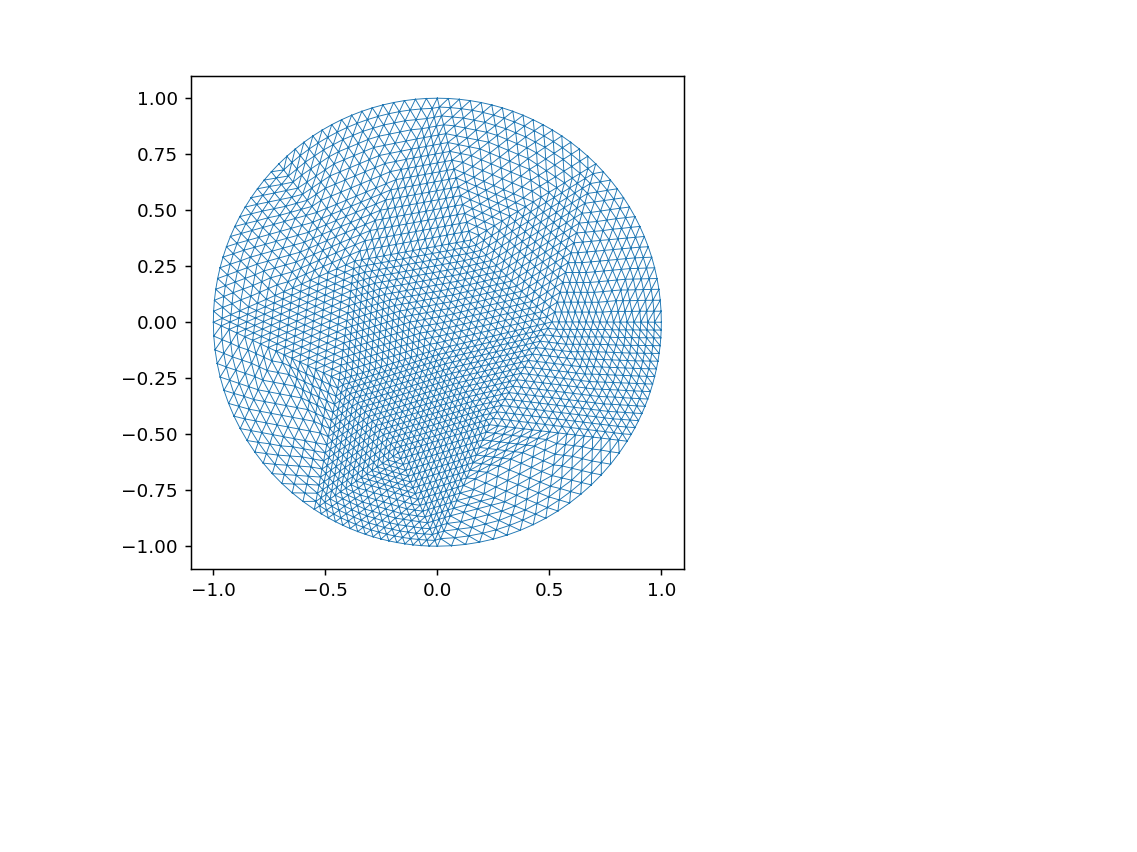

In [13]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5)
plt.axis("image");

In [5]:
def green_fun(rho, phi, r, theta):
    """
    Green function for Poisson equation in a circular domain
    
    Parameters
    ----------
    rho : float
        Radial coordinate for the loading point.
    phi : float
        Azimuthal coordinate for the loading point.
    r : float
        Radial coordinate for the observation point.
    theta : float
        Azimuthal coordinate for the observation point.

    Returns
    -------
    phi : float
        Value of the potential at (r, theta).
    """
    R = sqrt(r**2 - 2*r*rho*cos(theta - phi) + rho**2)
    Rc = sqrt(r**2 - 2*r/rho*cos(theta - phi) + 1/rho**2)
    return 0.5/pi * log(R/(Rc*rho))

In [6]:
def green_fun_grad(phi, r, theta):
    """
    Green function for Poisson equation in a circular domain
    
    Parameters
    ----------
    phi : float
        Azimuthal coordinate for the loading point.
    r : float
        Radial coordinate for the observation point.
    theta : float
        Azimuthal coordinate for the observation point.

    Returns
    -------
    phi : float
        Value of the potential at (r, theta).
    """
    cos_d = cos(theta) * cos(phi) + np.sin(theta)*np.sin(phi)
    return 0.5/pi * (1 - r**2)/(1 - 2*r*cos_d + r**2)

In [7]:
def area_tri(coords):
    """Compute the area of a triangle with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the triangle.

    Returns
    -------
    area : float
        Area of the triangle
    """
    mat = coords.copy()
    mat[:, 2] = 1
    return 0.5 * np.abs(np.linalg.det(mat))

In [8]:
def length_line(coords):
    """Compute length and norma a line with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the line.

    Returns
    -------
    area : float
        Area of the triangle
    """
    vec = coords[1, :] - coords[0, :]
    L = np.linalg.norm(vec)
    return L

In [9]:
def eval_values(eval_pts, pts, tris, lines, source, boundary):
    """
    Evaluate the solution inside the disk for
    a given source.

    Parameters
    ----------
    eval_pts : ndarray, float
        Coordinates for the nodes of evaluation.
    pts : ndarray, float
        Coordinates for the nodes of the triangle.
    tris : ndarray, int
        Connectivity for the triangles.
    source : callable
        Source term.

    Returns
    -------
    potential : ndarray, float
        Potential evaluated at each observation point.
    """
    potential = np.zeros_like(eval_pts[:, 0])
    for cont, pt in enumerate(eval_pts):
        pt_x, pt_y, _ = pt
        r = np.sqrt(pt_x**2 + pt_y**2)
        theta = np.arctan2(pt_y, pt_x)
        if np.isclose(r, 1):
            potential[cont] = boundary(theta)
        else:
            for tri in tris:
                coords = pts[tri]
                area = area_tri(coords)
                xm, ym, _ = np.mean(coords, axis=0)
                f = source(xm, ym)
                rho = np.sqrt(xm**2 + ym**2)
                phi = np.arctan2(ym, xm)
                pot = green_fun(rho, phi, r, theta)
                potential[cont] += area * pot * f
            for line in lines:
                coords = pts[line]
                L = length_line(coords)
                xm, ym, _ = np.mean(coords, axis=0)
                phi = np.arctan2(ym, xm)
                g = boundary(phi)
                pot = green_fun_grad(phi, r, theta)
                potential[cont] += L * pot * g
    return potential

## Example: uniform load

In this case we have the problem

$$\nabla^2 u(r, \theta) = 1\quad 0 < r < 1\, $$

with $u(1, \theta) = \cos(6\theta)$.


The analytical solution in this case is given by


$$u(r) = r^6 \cos(6\theta) + \frac{(r^2 - 1)}{4}\, .$$

In [14]:
source = lambda xm, ym: 1
boundary = lambda theta: cos(6*theta)
potential = eval_values(pts, pts, tris, lines, source, boundary)

<IPython.core.display.Javascript object>


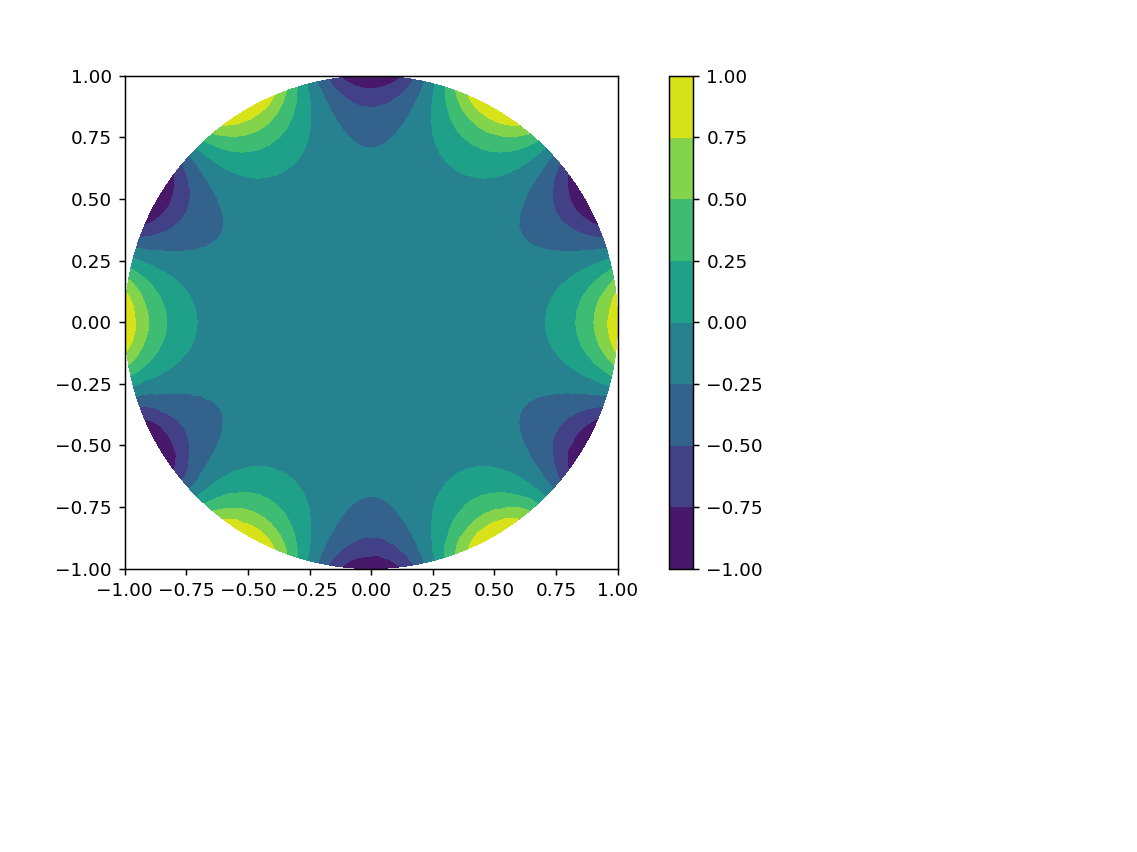

In [18]:
plt.figure()
plt.tricontourf(x, y, tris, potential)
plt.colorbar()
plt.axis("image");

The following plot shows the error.

<IPython.core.display.Javascript object>


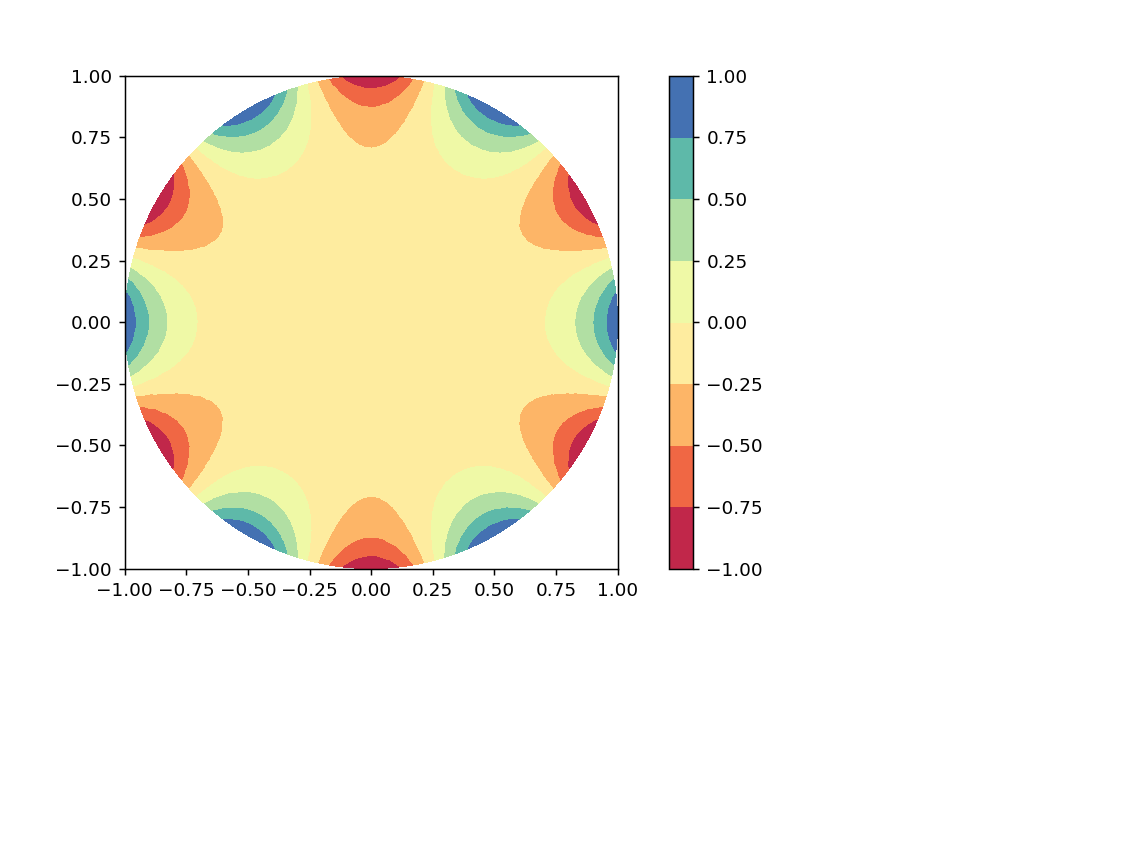

In [23]:
plt.figure()
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
plt.tricontourf(x, y, tris, r**6*np.cos(6*theta) + 0.25*(r**2 - 1),
                cmap="Spectral")
plt.colorbar()
plt.axis("image");

In [24]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'custom.css'
HTML(open(css_file, "r").read())